# Training GPT models to generate Bob Dylan lyrics:

Generating new Bob Dylan lyrics using [Andre Karpathy's nanoGPT repository](https://github.com/karpathy/nanoGPT/tree/master), which allows us to train GPT models from scratch, as well as leverage GPT models pre-trained of openweb text and fine-tuned on Bob Dylan.

We train four models:

1) Character-level model, trained from scratch on Bob Dylan lyrics

2) Subword token model, trained from scratch on Bob Dylan lyrics

3) Subword token model, trained from scratch on Bob Dylan lyrics, with different set of hyperparameters

4) Subword token model pre-trained on openweb text, and fine-tuned on Bob Dylan lyrics (MOST PROMISING)

Models trained in Google Colab Pro using an NVIDIA Tesla V100 GPU (very slow without GPU acceleration).

In [1]:
# mounting Google drive, where all the code lives in 'nanoGPT'

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Necessary reinstallation of cuda so that the model can be compiled (ran into issues without first running this step)

!nvcc --version

!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/11.0.3/local_installers/cuda-repo-ubuntu1804-11-0-local_11.0.3-450.51.06-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu1804-11-0-local_11.0.3-450.51.06-1_amd64.deb
!sudo apt-key add /var/cuda-repo-ubuntu1804-11-0-local/7fa2af80.pub
!sudo apt-get update
!sudo apt-get -y install cuda


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
--2023-12-12 01:10:59--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.20.126
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu1804.pin’

cuda-ubuntu1804.pin 100%[===================>]     190  --.-KB/s    in 0s      

2023-12-12 01:10:59 (19.2 MB/s) - ‘cuda-ubuntu1804.pin’ saved [190/190]

--2023-12-12 01:10:59--  https://developer.download.nvidia.com/compute/cuda/11.0.3/local_installers/cuda-repo-ubuntu1804-11-0-local_11.0.3-450.51.06-1_amd64.deb
Resolving developer.download.nvidia.c

In [3]:
!pip install torch numpy transformers datasets tiktoken wandb tqdm better_profanity -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which i

In [5]:
# Importing the libraries we need and setting the directory
# Importing the functions we wrote to plot loss and do postprocessing on the generated lyrics

import os
os.chdir('/content/drive/MyDrive/nanoGPT_lyrics')
import torch
import csv
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from utils.lyrics_utils import postprocessing_lyrics
from utils.lyrics_utils import plot_loss
from better_profanity import profanity



In [6]:
# Ensuring that we are using a GPU

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
1
0
Tesla V100-SXM2-16GB
11.8


# Training GPT models and generating sample lyrics

# Model 1: Character-level model (Bob Dylan)

In [ ]:
# Preparing the character model

!python data/lyrics_char/prepare.py --artist='Bob Dylan'

length of dataset in characters: 1,177,448
all the unique characters: 
 !"$&'()*+,-./0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|}ÉàáâãçéêíñóôõúüБВЗИКМНОСТЭабвгдежзийклмнопрстухцчшыьюяё –—‘’“”…‪‬ 
vocab size: 152
train has 1,059,703 tokens
val has 117,745 tokens


In [ ]:
# Training the character model - Bob Dylan

!python train.py config/train_lyrics_char.py

Overriding config with config/train_lyrics_char.py:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 23 00:32:58 2023

@author: benjaminheuberger
"""

# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-lyrics-char'
eval_interval = 200 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'lyrics-char'
wandb_run_name = 'mini-gpt'

dataset = 'lyrics_char'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3 # with baby networks can afford to go a bit higher
max_iters = 5000
lr_decay_iters = 5000 # make equal to max_iters us

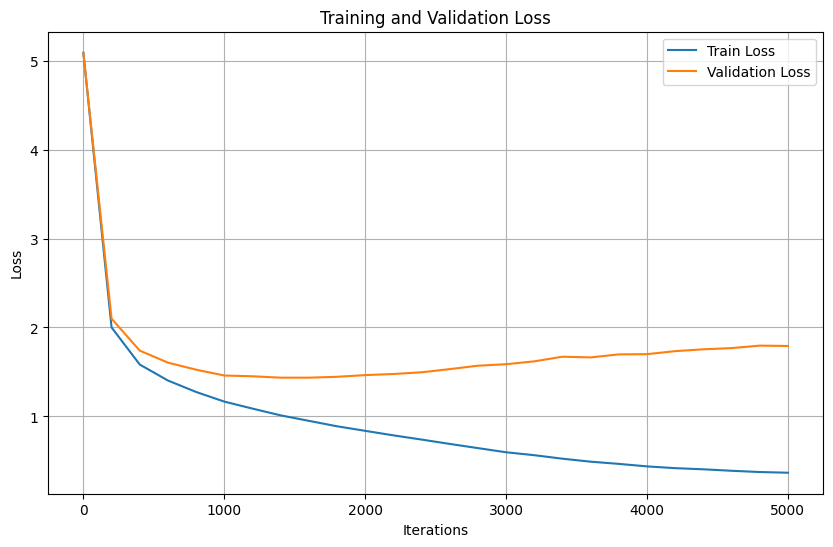

In [ ]:
# Plot the loss using the plotting function

plot_loss(out_dir='out-lyrics-char')

In [ ]:
# Generating 50 new samples of 2000 tokens each
# Generated songs are saved to a yaml file in the out directory

!python sample_refined.py --out_dir=out-lyrics-char --num_samples=50 --max_new_tokens=2000


Overriding: out_dir = out-lyrics-char
Overriding: num_samples = 50
Overriding: max_new_tokens = 2000
number of parameters: 10.68M
Loading meta from data/lyrics_char/meta.pkl...


In [ ]:
# Load the YAML file to print some examples
out_dir = 'out-lyrics-char'
yaml_path = os.path.join(out_dir, 'generated_songs.yaml')

with open(yaml_path, 'r') as file:
    generated_songs = yaml.safe_load(file)

# Printing some examples
for i in range(1,5):
  print(f'\n ------------GENERATED SONG {i} ----------- \n')
  print(generated_songs[f'Generated Song {i}'])


 ------------GENERATED SONG 1 ----------- 

[Verse 1]
I peeked up the botk of the cross
The bottom ship was coming and fall
I have been scrange sailors to divide the crowd
Where she didn't care where it need
See Bob Dylan LiveGet tickets as low as $57You might also like[Chorus]
I ain't got no funny, no fur days something to say
See Bob Dylan LiveGet tickets as low as $57You might also like[Refrain]
You got me baby my baby
I ain't got no fire weary night
But I can’t come back again
But I said the people said that you may be a long right
You said someone you said that I might be a night, baby
You said I just wanted a light or draw way
I just took a little to blow, baby
You may be a little too long to bring her baby

Be a little too long as your memory grassed as a little star
You may be a little way
You may be a little way done to her
Bring me a little short in the mirror
See Bob Dylan LiveGet tickets as low as $57You might also like[Chorus]
In the jail of the mirror of the mirror
When 

# Model 2: Tiktoken model trained from scratch (more simple) (Bob Dylan)

Note: very prone to overfitting the training data, replicating exact sections of real lyrics when sampling

In [ ]:
# Preparing the lyrics data for training

!python data/lyrics/prepare.py --artist='Bob Dylan'

train has 299,306 tokens
val has 35,348 tokens


In [ ]:
# Training the tiktoken model with a custom set of hyperparameters

!python train.py --dataset=lyrics --out_dir=out-lyrics-2 \
--n_layer=4 --n_head=4 --n_embd=128 --eval_iters=50 --block_size=128 \
--batch_size=8 --max_iters=1000 --eval_interval=100 --log_interval=10

Overriding: dataset = lyrics
Overriding: out_dir = out-lyrics-2
Overriding: n_layer = 4
Overriding: n_head = 4
Overriding: n_embd = 128
Overriding: eval_iters = 50
Overriding: block_size = 128
Overriding: batch_size = 8
Overriding: max_iters = 1000
Overriding: eval_interval = 100
Overriding: log_interval = 10
tokens per iteration will be: 40,960
Initializing a new model from scratch
defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)
number of parameters: 7.23M
num decayed parameter tensors: 18, with 7,241,728 parameters
num non-decayed parameter tensors: 9, with 1,152 parameters
using fused AdamW: True
compiling the model... (takes a ~minute)
step 0: train loss 10.8493, val loss 10.8488
iter 0: loss 10.8614, time 15576.66ms, mfu -100.00%
iter 10: loss 10.8402, time 265.21ms, mfu 2.19%
iter 20: loss 10.8051, time 278.01ms, mfu 2.18%
iter 30: loss 10.7438, time 284.14ms, mfu 2.16%
iter 40: loss 10.6692, time 263.52ms, mfu 2.17%
iter 50: loss 10.5826, time 263.64

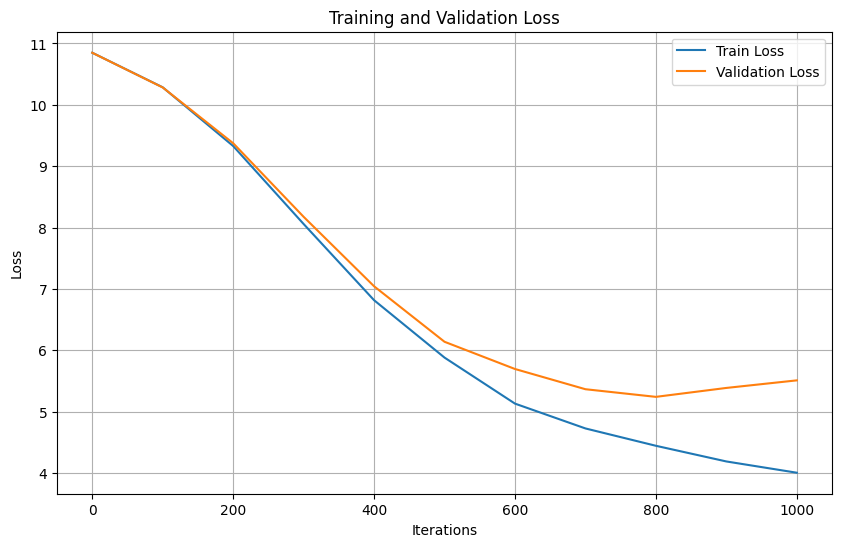

In [ ]:
# Plot the loss using the plotting function

plot_loss(out_dir='out-lyrics-2')

In [ ]:
# Generating 50 new samples of 1000 tokens each
# Generated songs are saved to a .yaml file in the out directory

!python sample_refined.py --out_dir=out-lyrics-2 --num_samples=10 --max_new_tokens=1000

Overriding: out_dir = out-lyrics-2
Overriding: num_samples = 10
Overriding: max_new_tokens = 1000
number of parameters: 7.23M
No meta.pkl found, assuming GPT-2 encodings...


In [ ]:
# Load the YAML file to print some examples
out_dir = 'out-lyrics-2'
yaml_path = os.path.join(out_dir, 'generated_songs.yaml')

with open(yaml_path, 'r') as file:
    generated_songs = yaml.safe_load(file)

# Printing some examples
for i in range(1,5):
  print(f'\n ------------GENERATED SONG {i} ----------- \n')
  print(generated_songs[f'Generated Song {i}'])


 ------------GENERATED SONG 1 ----------- 

[Verse 1]
Now you think
I'm in the river
I'm a maid-o' in my head
I want to see me baby
With the time
[Verse 2]
She was no woman for you
I been so much
But I had to me
I will be you
[Chorus]
I must
[Verse 4]
I'll have don't always a long
I'm a man, I've been up in my life
Say the wrong
We'm gonna bring you say I'm in my heart
Is a more
And I'll be a-going to be a-t
[Verse 2]
Take a love
Since I'm a little time I'm gonna ever see


[Verse 4]
I see you my baby, I was a lot of my mind
That I'm a fool's a-shado
I'm a-calling
Are you, I'm a thousand hair was a dream's one, I'm just mine
Oh if I'm a-up one-huh

Oh, I ain't just for you say, I'm a-z
She don't go a damn, and I'm a morning

[Chorus]
Pre-going out of my face'd just who came, but I'll gonna go
But it's a minute, but I know this night
I've been up my
[Verse 9]
One time I'm all I can't sure I don't always
Well, Lord, I'll be a-huh
I don't take me looking for you here
All I'm a I'm gonna 

# Model 3: Tiktoken model trained from scratch (more complex) (Bob Dylan)

Note: very prone to overfitting the training data, replicating exact sections of real lyrics when sampling

In [ ]:
!python data/lyrics/prepare.py

train has 299,306 tokens
val has 35,348 tokens


In [ ]:
# Increasing the architecture complexity (number of layers, number of attention heads), embedding dimensions, and block size
# Also adding some dropout to help avoid some potential overfitting
# Only saving checkpoint if it improves validation loss

!python train.py --dataset=lyrics --always_save_checkpoint=False --out_dir=out-lyrics-3 \
--n_layer=6 --n_head=6 \
--dropout=0.2 --n_embd=240 --block_size=256 --batch_size=8 \
--max_iters=1000 --eval_interval=100 --eval_iters=50 --log_interval=10

Overriding: dataset = lyrics
Overriding: always_save_checkpoint = False
Overriding: out_dir = out-lyrics-3
Overriding: n_layer = 6
Overriding: n_head = 6
Overriding: dropout = 0.2
Overriding: n_embd = 240
Overriding: block_size = 256
Overriding: batch_size = 8
Overriding: max_iters = 1000
Overriding: eval_interval = 100
Overriding: eval_iters = 50
Overriding: log_interval = 10
tokens per iteration will be: 81,920
Initializing a new model from scratch
defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)
number of parameters: 16.22M
num decayed parameter tensors: 26, with 16,281,600 parameters
num non-decayed parameter tensors: 13, with 3,120 parameters
using fused AdamW: True
compiling the model... (takes a ~minute)
step 0: train loss 10.8996, val loss 10.8967
iter 0: loss 10.8920, time 27489.85ms, mfu -100.00%
iter 10: loss 10.8403, time 452.33ms, mfu 5.91%
iter 20: loss 10.6450, time 452.50ms, mfu 5.91%
iter 30: loss 10.5006, time 452.95ms, mfu 5.91%
iter 40: l

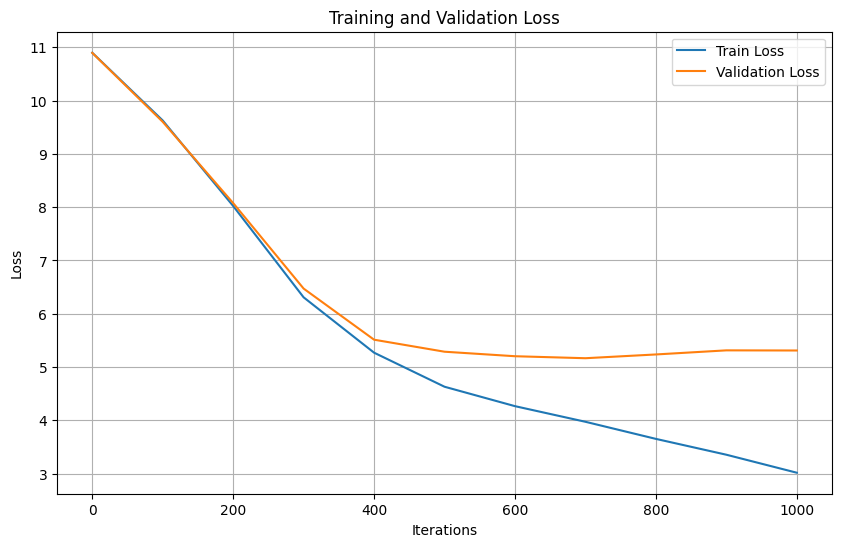

In [ ]:
# Plot the loss using the plotting function

plot_loss(out_dir='out-lyrics-3')

In [ ]:
# Generating 50 new samples of 1000 tokens each
# Generated songs are saved to a .yaml file in the out directory

!python sample_refined.py --out_dir=out-lyrics-3 --num_samples=50 --max_new_tokens=1000

Overriding: out_dir = out-lyrics-3
Overriding: num_samples = 50
Overriding: max_new_tokens = 1000
number of parameters: 16.22M
No meta.pkl found, assuming GPT-2 encodings...


In [ ]:
# Load the YAML file to print some examples
out_dir = 'out-lyrics-3'
yaml_path = os.path.join(out_dir, 'generated_songs.yaml')

with open(yaml_path, 'r') as file:
    generated_songs = yaml.safe_load(file)

# Printing some examples
for i in range(1,5):
  print(f'\n ------------GENERATED SONG {i} ----------- \n')
  print(generated_songs[f'Generated Song {i}'])


 ------------GENERATED SONG 1 ----------- 

[Verse 1]
I'm so many people
You say my way so soon
And it's a sweet than you
Can't die with me baby
[Verse 10]
Now you love but I'd have to do
Let me
Not as I'm rolling night
And pray
The wind of my heart
Don't have a big
[Verse 4]
You'll have to shoot me a long
I'm with you
[Verse 2]
I'll tell you, all alone
Well, I say I'm in my heart
Sometimes I'm a fool in the morning
I'm this time
I'm a child
Well, I'm going to my heart's a fool
I'm a-em, I'm a man at night
I see
I'm all my baby
I was a lot of my baby
That's a-eyed death's a-eyed father, but I'm leavin'
I've been time
I was a dream's one, I'm just will I'm free
I'm a-one"It's just a-of-gonna be for you say, I'm a-and-d be
I'll be, I'm just did be a-gent

I'm in love
Some very

I'm going to love
I'm a-blin' up my own
I'm on my head
And I'm your heart
[Chorus]
One time
When all my love
[Verse 2]
I'm a-hit dream I'm lost hard, a-d goin'
I'm sorry
I'm a-way-eyed love that's nothin'
I'm a-g

# MODEL 4: Pre-trained tiktoken model fine-tuned on lyrics data (Bob Dylan)

This seems to work best but prone to some repetition

In [ ]:
# Preparing the lyrics data for training

!python data/lyrics/prepare.py

train has 299,306 tokens
val has 35,348 tokens


In [ ]:
# Training the lyrics with custom configuration over a max of 300 iterations

!python train.py config/finetune_lyrics.py

Overriding config with config/finetune_lyrics.py:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 23 00:54:17 2023

@author: benjaminheuberger
"""

import time

out_dir = 'out-lyrics'
eval_interval = 50
eval_iters = 50
#always_save_checkpoint=False 
wandb_log = False # feel free to turn on
wandb_project = 'lyrics'
wandb_run_name = 'ft-' + str(time.time())

dataset = 'lyrics'
init_from = 'gpt2'

# only save checkpoints if the validation loss improves
#always_save_checkpoint = False

batch_size = 1
gradient_accumulation_steps = 32
max_iters = 300

# finetune at constant LR
#learning_rate = 9e-5
#learning_rate = 3e-5
learning_rate = 2e-4
#learning_rate = 3e-5
#decay_lr = True

# additional 
dropout = 0.1 
tokens per iteration will be: 32,768
Initializing from OpenAI GPT-2 weights: gpt2
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.1
number of parameters: 123.65M
num decayed parameter tensor

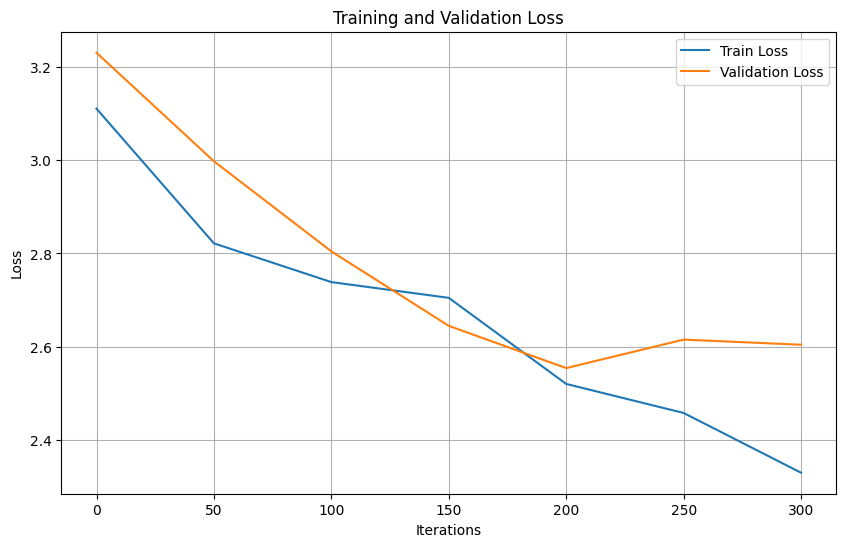

In [ ]:
# Plot the loss using the plotting function

plot_loss(out_dir='out-lyrics')

In [ ]:
# Generating 50 new samples of 1000 tokens each
# Generated songs are saved to a .yaml file in the out directory

!python sample_refined.py --out_dir=out-lyrics --num_samples=50 --max_new_tokens=1000

Overriding: out_dir = out-lyrics
Overriding: num_samples = 50
Overriding: max_new_tokens = 1000
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...


In [ ]:
# Load the YAML file

out_dir = 'out-lyrics'
yaml_path = os.path.join(out_dir, 'generated_songs.yaml')

with open(yaml_path, 'r') as file:
    generated_songs = yaml.safe_load(file)

In [7]:
# Defining the new post-processing function

def postprocessing_lyrics(lyrics):
    """
    Improves the formatting and structure of lyric output to better reflect an actual song

    Args:
    lyrics (str): A string of generated lyrics

    Returns:
    str: Cleaned lyrics
    """

    # Split the lyrics by new lines
    lines = lyrics.split('\n')
    verse_count = 0

    # Criteria 1: Insert blank lines where missing between a verse header and prior paragraph
    for i in range(len(lines)):
        line = lines[i]
        if line.startswith("[Verse"):
            verse_count += 1
            if i > 0 and lines[i - 1] != '' and not lines[i - 1].startswith("[Verse"):
                lines.insert(i, '')

    # Criteria 2: Ensure verse numbers count up and never down
    expected_verse = 1
    for idx, line in enumerate(lines):
        if line.startswith("[Verse") and ']' in line:
            try:
              verse_num = int(line.split(']')[0][7:])
              if verse_num < expected_verse:
                  # Truncate at the last complete verse before the violation
                  lines = lines[:idx]
                  break
              expected_verse += 1
            except ValueError:
              continue

    # Criteria 3: Truncate at the last complete verse
    for i in range(len(lines) - 1, -1, -1):
        if lines[i] == '':
            lines = lines[:i]
            break

    # Reconstruct cleaned lyrics
    cleaned_lyrics = '\n'.join(lines)
    return cleaned_lyrics

In [ ]:
# Cleaning up the generated songs and printing them again
out_dir = 'out-lyrics'

generated_songs_clean = {}

for song, lyrics in generated_songs.items():
  lyrics = "\n" + str(lyrics) # this is necessary because colab is trimming the first line for some reason
  clean_lyrics = postprocessing_lyrics(lyrics)
  generated_songs_clean[song] = clean_lyrics


  yaml_path = os.path.join(out_dir, 'generated_songs_clean.yaml')
with open(yaml_path, 'w') as file:
    yaml.dump(generated_songs, file)


In [ ]:
# Comparing a few examples before and after the cleaning

for i in range(1,10):
  print(f'\n ------------SONG {i} ORIGINAL ----------- \n')
  print(generated_songs[f'Generated Song {i}'])

  print(f'\n ------------SONG {i} CLEAN ----------- \n')
  print(generated_songs_clean[f'Generated Song {i}'])



 ------------SONG 1 ORIGINAL ----------- 

[Verse 1]
God's Son
I'm in the kitchen
I'm in the kitchen and I'm hungry
I'm in the kitchen and I'm hungry
I'm in the kitchen and I'm hungry
God's Son’s been gone’
God’s been gone’

[Chorus]
I’m a-going down to the river
I'm going down to the river
I'm going down to the river

[Verse 2]
We’re all together
We’re all together
We’re all together
We're all together
God’s been gone’
God’s been gone’

[Chorus]
I'm a-going down to the river
I'm going down to the river
I'm going down to the river
God’s been gone’
God’s been gone’

[Verse 3]
They're all gone
They’re all gone
They’re all gone
God’s been gone’

[Chorus]
I'm a-going down to the river
I'm going down to the river
I'm going down to the river
God’s been gone’

[Verse 4]
They’re all gone
They’re all gone
God’s been gone’

[Chorus]
I'm a-going down to the river
I'm going down to the river
I'm going down to the river
God’s been gone’

[Verse 5]
They’re all gone
They’re all gone
God’s been gone’

# Taylor Swift Section

# Model 1: Character Level Model (Taylor Swift)

In [ ]:
# Preparing the character model

!python data/lyrics_char/prepare.py --artist='Taylor Swift'

Using artist: Taylor Swift
length of dataset in characters: 838,050
all the unique characters: 
 !"#$%&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz} ÉØáãéíñóúе ​–—‘’“”… 🌈🔥🗳😃
vocab size: 110
train has 754,245 tokens
val has 83,805 tokens


Overriding config with config/train_lyrics_char_Swift.py:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 23 00:32:58 2023

@author: benjaminheuberger
"""

# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-lyrics-char-Swift'
eval_interval = 200 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'lyrics-char'
wandb_run_name = 'mini-gpt'

dataset = 'lyrics_char'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3 # with baby networks can afford to go a bit higher
max_iters = 2000
lr_decay_iters = 2000 # make equal to 

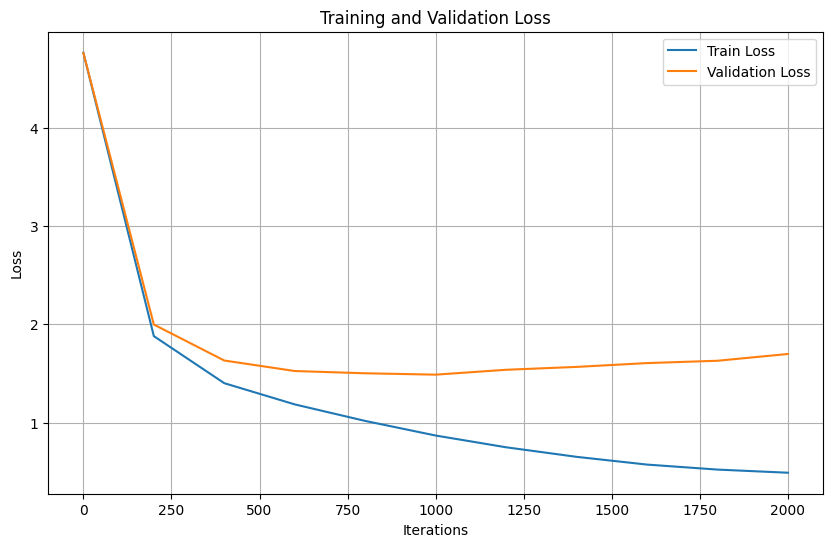

In [ ]:
# Training the character model

!python train.py config/train_lyrics_char_Swift.py
plot_loss(out_dir='out-lyrics-char-Swift')

In [ ]:
# Generating new lyrics and saving them to the yaml file in the out directory
!python sample_refined.py --out_dir=out-lyrics-char-Swift --num_samples=50 --max_new_tokens=2000

# Load the YAML file to print some examples
out_dir = 'out-lyrics-char-Swift'
yaml_path = os.path.join(out_dir, 'generated_songs.yaml')

with open(yaml_path, 'r') as file:
    generated_songs = yaml.safe_load(file)

# Printing some examples
for i in range(1,5):
  print(f'\n ------------GENERATED SONG {i} ----------- \n')
  print(generated_songs[f'Generated Song {i}'])

Overriding: out_dir = out-lyrics-char-Swift
Overriding: num_samples = 50
Overriding: max_new_tokens = 2000
number of parameters: 10.66M
Loading meta from data/lyrics_char/meta.pkl...

 ------------GENERATED SONG 1 ----------- 

[Verse 1]
He said I won't be a bit of crying to my side
He's good to started and a while skies and hear
But he didn't the crazy, guitar
He's so scared of scared of replace
He's so glitten fake a chase lists of empty inside
Now the time all the to call about me, how feels the different
We didn’t keep the antics
And I would be the one I would ever love you

[Chorus]
But I was just a lot my old on a girl
We're stord, picture out of time in the life
He's the same purprince are the night, there is not a passensed my shine
He's looking down and he's seen a first kind
He's getting her hold at his face
And they we put up in my hand
Hello, I think he's just on, the things I thought
So I'll follow your heart, feel this time
This love is the last time I'll be enough
I'm a 

# Model 3 (Taylor Swift)
Skipping model 2 because model 3 has demonstrated better performance.

In [ ]:
# Preparing the data for training
!python data/lyrics/prepare.py --artist='Taylor Swift'

Using artist: Taylor Swift
train has 217,031 tokens
val has 23,680 tokens


In [ ]:
# Training the model using the same model 3 configuration as the Bob Dylan data
!python train.py --dataset=lyrics --always_save_checkpoint=False --out_dir=out-lyrics-3-Swift \
--n_layer=6 --n_head=6 \
--dropout=0.2 --n_embd=240 --block_size=256 --batch_size=8 \
--max_iters=1000 --eval_interval=100 --eval_iters=50 --log_interval=10


Overriding: dataset = lyrics
Overriding: always_save_checkpoint = False
Overriding: out_dir = out-lyrics-3-Swift
Overriding: n_layer = 6
Overriding: n_head = 6
Overriding: dropout = 0.2
Overriding: n_embd = 240
Overriding: block_size = 256
Overriding: batch_size = 8
Overriding: max_iters = 1000
Overriding: eval_interval = 100
Overriding: eval_iters = 50
Overriding: log_interval = 10
tokens per iteration will be: 81,920
Initializing a new model from scratch
defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)
number of parameters: 16.22M
num decayed parameter tensors: 26, with 16,281,600 parameters
num non-decayed parameter tensors: 13, with 3,120 parameters
using fused AdamW: True
compiling the model... (takes a ~minute)
step 0: train loss 10.9070, val loss 10.9068
iter 0: loss 10.9123, time 27415.48ms, mfu -100.00%
iter 10: loss 10.8450, time 448.85ms, mfu 5.95%
iter 20: loss 10.6976, time 449.52ms, mfu 5.95%
iter 30: loss 10.4650, time 448.41ms, mfu 5.95%
iter

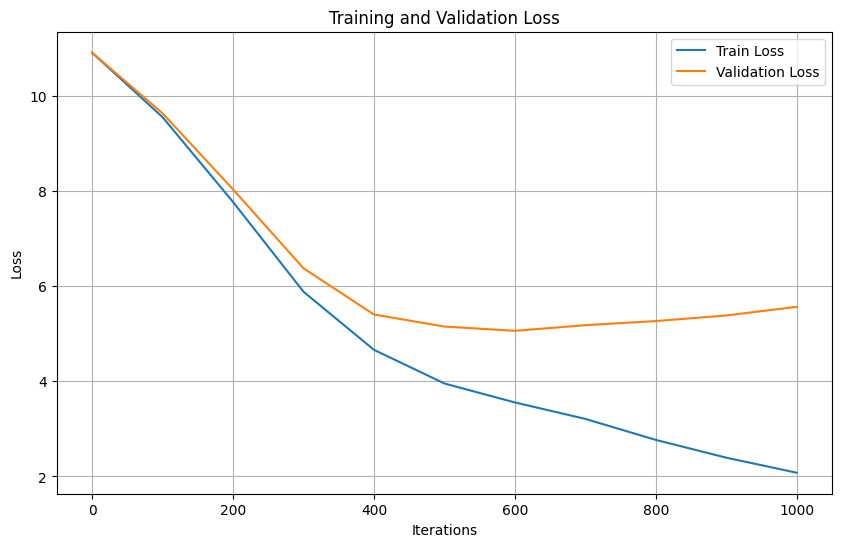

In [ ]:
# Plotting the loss
plot_loss(out_dir='out-lyrics-3-Swift')

In [ ]:
!python sample_refined.py --out_dir=out-lyrics-3-Swift --num_samples=50 --max_new_tokens=1000

# Load the YAML file to print some examples
out_dir = 'out-lyrics-3-Swift'
yaml_path = os.path.join(out_dir, 'generated_songs.yaml')

with open(yaml_path, 'r') as file:
    generated_songs = yaml.safe_load(file)

# Printing some examples
for i in range(1,5):
  print(f'\n ------------GENERATED SONG {i} ----------- \n')
  print(generated_songs[f'Generated Song {i}'])

Overriding: out_dir = out-lyrics-3-Swift
Overriding: num_samples = 50
Overriding: max_new_tokens = 1000
number of parameters: 16.22M
No meta.pkl found, assuming GPT-2 encodings...

 ------------GENERATED SONG 1 ----------- 

[Verse 1]
I'm the young to be the day
I'm his life
Red, beautiful, take it's a second, oh, baby, oh
I'll be the good day than coming on a song
What they smile
We're gonna be the flowers who you're not an dream
[Chorus]
You could be the dead's a bad blood, oh
Oh, don't always been be bad)
I didn't it's gonna be a love

Say you we don't help it's a blank shoes
[Verse 1]
But oh, oh
I used to be this love you know
[Chorus: Taylor Swift]
It's the game
I don't you're alright
And I'll be
Like baby, stay see you, but you know
You're in this
[Verse 1]
Your heart
I can't see you gotta be blue
[Pre-Chorus]
You're not there was a dream's you, oh, just mine
Oh, oh
Sle of paper sky
If you, baby, I ain't just for you say, womm
Oh, oh
And I go down
But I'm just did it's the day

W

# Model 4 (Taylor Swift)

The best performing Bob Dylan model trained on Taylor Swift using the same parameters

In [ ]:
# Preparing the data for training
!python data/lyrics/prepare.py --artist='Taylor Swift'

Using artist: Taylor Swift
train has 217,031 tokens
val has 23,680 tokens


Overriding config with config/finetune_lyrics_Swift.py:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 23 00:54:17 2023

@author: benjaminheuberger
"""

import time

out_dir = 'out-lyrics-Swift'
eval_interval = 50
eval_iters = 50
#always_save_checkpoint=False 
wandb_log = False # feel free to turn on
wandb_project = 'lyrics'
wandb_run_name = 'ft-' + str(time.time())

dataset = 'lyrics'
init_from = 'gpt2'

# only save checkpoints if the validation loss improves
#always_save_checkpoint = False

batch_size = 1
gradient_accumulation_steps = 32
max_iters = 300

# finetune at constant LR
#learning_rate = 9e-5
#learning_rate = 3e-5
learning_rate = 2e-4
#learning_rate = 3e-5
#decay_lr = True

# additional 
dropout = 0.1 
tokens per iteration will be: 32,768
Initializing from OpenAI GPT-2 weights: gpt2
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.1
number of parameters: 123.65M
num decayed para

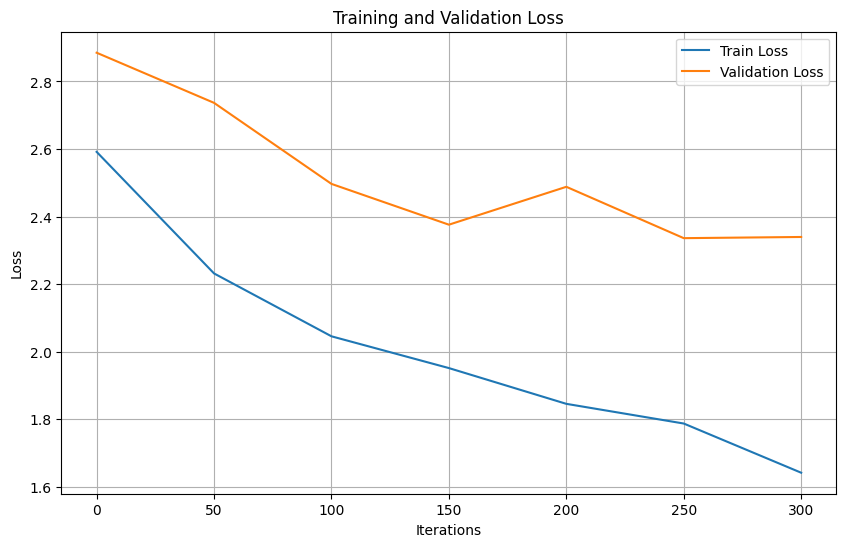

In [ ]:
# Training the model and plotting the loss
!python train.py config/finetune_lyrics_Swift.py
plot_loss(out_dir='out-lyrics-Swift')

In [ ]:
# Generating new songs and saving them to a yaml file in the out directory
!python sample_refined.py --out_dir=out-lyrics-Swift --num_samples=50 --max_new_tokens=1000

Overriding: out_dir = out-lyrics-Swift
Overriding: num_samples = 50
Overriding: max_new_tokens = 1000
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...


In [ ]:
# Doing post-processing on the generated lyrics

out_dir = 'out-lyrics-Swift'
yaml_path = os.path.join(out_dir, 'generated_songs.yaml')

with open(yaml_path, 'r') as file:
    generated_songs = yaml.safe_load(file)

generated_songs_clean = {}

for song, lyrics in generated_songs.items():
  lyrics = "\n" + str(lyrics) # this is necessary because colab is trimming the first line for some reason
  clean_lyrics = postprocessing_lyrics(lyrics)
  generated_songs_clean[song] = clean_lyrics

  yaml_path = os.path.join(out_dir, 'generated_songs_clean.yaml')
with open(yaml_path, 'w') as file:
    yaml.dump(generated_songs, file)

In [ ]:
#Printing the songs before and after the post-processing

for i in range(1,10):
  print(f'\n ------------SONG {i} ORIGINAL ----------- \n')
  print(generated_songs[f'Generated Song {i}'])

  print(f'\n ------------SONG {i} CLEAN ----------- \n')
  print(generated_songs_clean[f'Generated Song {i}'])


 ------------SONG 1 ORIGINAL ----------- 

[Verse 1]
Before you think
I'm in the kitchen
Grabbing a pastry for dinner
Grew up in a real bad family
I got a lot to teach you
Now you're coming home from school and I'm out
We're gonna walk home
And you're sitting in the passenger seat
And I'm like, oh, you got it wrong
I got a long list of things to do
But I didn't want you messing with me

[Pre-Chorus]
We started our song
Oh, I wanna sing
Everybody knows this song
And it's gonna be the worst
I think we're gonna stay out of this
Makes me wanna crash
And I don't wanna risk it
And I don't wanna go out there alone

[Chorus]
You got a long list of things to do
But I didn't want you messing with me

[Verse 2]
Before you think
I'm in the kitchen
Grabbing a pastry for dinner
Grew up in a real bad family
I got a lot to teach you
Now you're coming home from school and I'm out
We're gonna walk home
And you're sitting in the passenger seat
And I'm like, oh, you got it wrong
I got a long list of thin

# Model 4 (Snoop Dogg)

Since model 4 generated the best quality lyrics, we just train this model for Snoop Dogg.

In [ ]:
# Preparing the data for training
!python data/lyrics/prepare.py --artist='Snoop Dogg'

Using artist: Snoop Dogg
train has 526,508 tokens
val has 59,814 tokens


Overriding config with config/finetune_lyrics_Snoop_Dogg.py:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 23 00:54:17 2023

@author: benjaminheuberger
"""

import time

out_dir = 'out-lyrics-Snoop-Dogg'
eval_interval = 50
eval_iters = 50
#always_save_checkpoint=False 
wandb_log = False # feel free to turn on
wandb_project = 'lyrics'
wandb_run_name = 'ft-' + str(time.time())

dataset = 'lyrics'
init_from = 'gpt2'

# only save checkpoints if the validation loss improves
always_save_checkpoint = False

batch_size = 1
gradient_accumulation_steps = 32
max_iters = 500

# finetune at constant LR
#learning_rate = 9e-5
#learning_rate = 3e-5
learning_rate = 2e-4
#learning_rate = 3e-5
#decay_lr = True

# additional 
dropout = 0.1 
tokens per iteration will be: 32,768
Initializing from OpenAI GPT-2 weights: gpt2
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.1
number of parameters: 123.65M
num dec

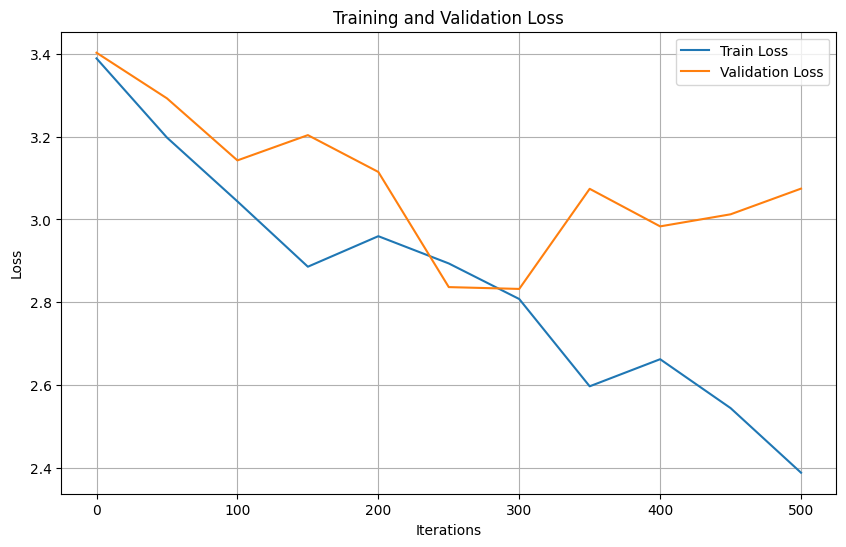

In [ ]:
#Training the model
!python train.py config/finetune_lyrics_Snoop_Dogg.py
plot_loss(out_dir='out-lyrics-Snoop-Dogg')

In [ ]:
# Generating new lyrics and saving them to a .yaml file
!python sample_refined.py --out_dir=out-lyrics-Snoop-Dogg --num_samples=50 --max_new_tokens=1000

Overriding: out_dir = out-lyrics-Snoop-Dogg
Overriding: num_samples = 50
Overriding: max_new_tokens = 1000
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...


In [11]:
# Doing post-processing on the generated Snoop Dogg lyrics

out_dir = 'out-lyrics-Snoop-Dogg'
yaml_path = os.path.join(out_dir, 'generated_songs.yaml')

with open(yaml_path, 'r') as file:
    generated_songs = yaml.safe_load(file)

generated_songs_clean = {}
generated_songs_censored = {}

for song, lyrics in generated_songs.items():
  lyrics = "\n" + str(lyrics) # this is necessary because colab is trimming the first line for some reason
  lyrics_censored = profanity.censor(lyrics) # censoring bad words
  lyrics_censored = postprocessing_lyrics(lyrics_censored)
  lyrics_uncensored = postprocessing_lyrics(lyrics)

  if len(lyrics_censored) > 1: # some songs occasionally get cut off completely
    generated_songs_censored[song] = lyrics_censored
    generated_songs_clean[song] = lyrics_uncensored
  else:
    generated_songs_censored[song] = profanity.censor(lyrics)
    generated_songs_clean[song] = lyrics

yaml_path = os.path.join(out_dir, 'generated_songs_clean.yaml')
with open(yaml_path, 'w') as file:
    yaml.dump(generated_songs_clean, file)

yaml_path_2 = os.path.join(out_dir, 'generated_songs_censored.yaml')
with open(yaml_path_2, 'w') as file:
    yaml.dump(generated_songs_censored, file)

In [13]:
for i in range(1,10):
  print(f'\n ------------SONG {i} ORIGINAL ----------- \n')
  print(generated_songs_censored[f'Generated Song {i}'])

  #print(f'\n ------------SONG {i} CLEAN ----------- \n')
  #print(generated_songs_clean[f'Generated Song {i}'])


 ------------SONG 1 ORIGINAL ----------- 


[Verse 1]
Now you think I'm a liar?
You so right
And that's why you take it easy
But don't pretend that you're an East Side rapper
Now you know what I'm talking about
But you never been to Williamsport
The West coast
And you have no clue
Cause I'm the light man, the light man
I'm the light man
I'm the light man
I'm the light man
I call me Lord
I'm the light man
We all call us Lord
The light man
I call him Lord

[Chorus]
Told you what the problem was
I told you this
Matter of fact, I told you this
You might also like[Verse 2]
I said, see how I see you
Lights out in this city hella, **** that's on, **** that's on, **** that's on
Let me get y'all off my back
Let me get y's off my back
Let me get y's off my back
Snoop Dogg's, Snoop Dogg's, Snoop Dogg's
They don't do what they wanna go on
But when I'm on it, the game's
We gon' try to get caught up
And try to get caught up
We gon' try to get caught up
We gon' try to get caught up

[Verse 3]
It's a